In [1]:
import os
import fy3
import configparser
import matplotlib.pyplot as plt

In [2]:
config = configparser.ConfigParser()
config.read('file_paths.ini')
config.sections()

['MAIN_DATA_PATH', 'FY3', 'HIMAWARI']

In [3]:
# File paths for FengYun-3E data.
FY3E_DATA_FOLDERS_LOCATION = config['FY3']['FY3E_MAIN_DATA_LOCATION']
FY3E_L0_DATA_LOCATION = config['FY3']['FY3E_L0_DATA_LOCATION']
FY3E_L1_DATA_LOCATION = config['FY3']['FY3E_L1_DATA_LOCATION']
FY3E_L1_GOE_DATA_LOCATION = config['FY3']['FY3E_L1_GOE_DATA_LOCATION']
FY3E_L1_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_IMAGE_DATA_LOCATION']
FY3E_L1_GEOREF_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_GEOREF_IMAGE_DATA_LOCATION']

In [4]:
fy3e_l1_geo_files_paths = [FY3E_L1_GOE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_GOE_DATA_LOCATION)]
fy3e_l1_image_files_paths = [FY3E_L1_IMAGE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_IMAGE_DATA_LOCATION)]

print('GEO files -', fy3e_l1_geo_files_paths)
print()
print('Image files -', fy3e_l1_image_files_paths)

GEO files - ['E:/Satellite data/FY-3E/L1/geo/FY3E_MERSI_GRAN_L1_20230228_2215_GEOQK_V0.HDF']

Image files - ['E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230228_2215_0250M_V0.HDF']


In [5]:
data = fy3.FY3EIrDnImg(fy3e_l1_image_files_paths[0])

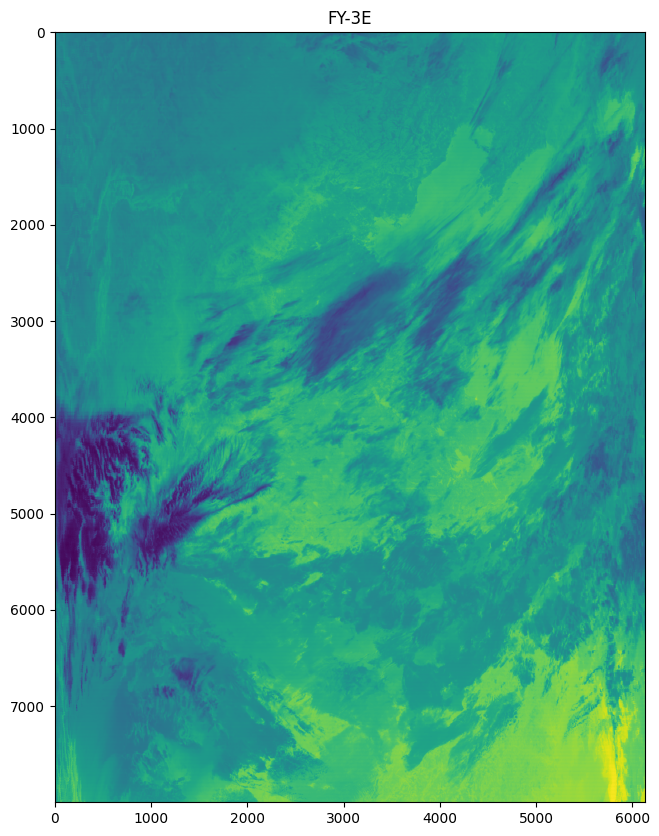

In [7]:
data.dn_data_b6.imshow(title=data.satellite_name)

In [7]:
sec_data = data.dn_data_b6.get_sections()

In [8]:
x, y = 4152, 1271

In [9]:
sec = sec_data.get_sector_by_index(x, y)

TypeError: Image data of dtype object cannot be converted to float

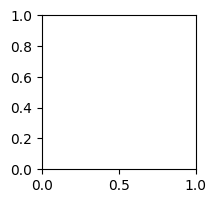

In [11]:
fy3.show_data(data.dn_data_b6)